# Minor Assignment 5: Finite Impulse Response filter

In [1]:
import sys 
from    StaccatoLab import *
import  numpy as np
import  matplotlib.pyplot  as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
version()

'StaccatoLab: version alpha.11'


Given graph `FIRp` below. Use the various view, sim, plot tools to analyze the program.

Create 2 copies of Graph `FIRp`, rename the Graphs, and modify their behaviors:
1. For the first copy: generate a list `rom` with 0.5 second (44.1Khz) of random ("white") noise 
with max amplitude (assuming data type `np.int16`). 
See https://en.wikipedia.org/wiki/White_noise for additional information. Validate whether the data in `rom` meets the requirements of white noise. 
  - Hint 1: A $[a,b]$-uniform distribution has mean $\frac{(a+b)}{2}$ and variation $\frac{(b-a)^2}{12}$. 
  - Hint 2: Construct a periodogram of the data in the rom, e.g., using a 2-node graph, consisting of a source and a sink only.
  - Hint 3: What would you expect if you consider a `rom`  with a greater duration, say, 5 seconds.
  
  
2. Plug this `rom` in node `G.SRC`, and analyze the behavior in time and frequency domain. 
Explain the dB level of the noise and the spectral attenuation.
3. For the second copy: generate a list `rom` containing a periodic pulse $M, 0, 0, ..., 0, M, 0, 0, .., 0, M,  0..$,
with $M$ = max amplitude, $f_s$ = 44.1 kHz, $f_{pulse}$ = 1kHz, duration=0.5 seconds. Hint: inspect the output for a smaller time segment, e.g. using `matplotlib`.
4. Plug `rom` in ... (as 2.)

Grading for the 4 questions: [3, 2, 3, 2]

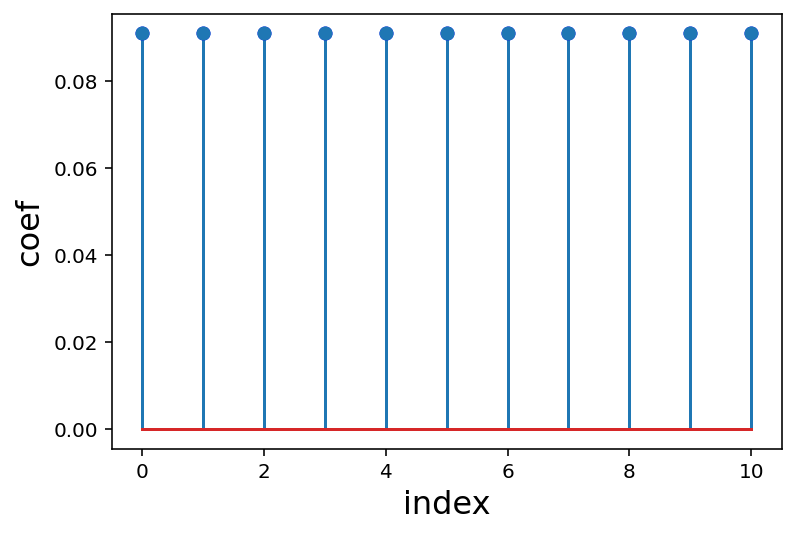

In [2]:
Nc=11
coef=[1/Nc for i in range(Nc)]
plt.xlabel('index', fontsize=16); plt.ylabel('coef', fontsize=16)
plt.plot(coef, 'bo'); plt.stem(coef, use_line_collection=True);

## Question 1

First, we need to know the range of `np.int16`.

In [3]:
ii16 = np.iinfo(np.int16)
a, b = ii16.min, ii16.max
a, b

(-32768, 32767)

Then we can generate white noise `rom` according to the requirements.

In [4]:
rate = 44100
t = 0.5
rom = np.random.uniform(low=a, high=b, size=int(rate*t))
rom.shape

(22050,)

### Validation check

Now we need to check we indeed generate required white noise.

#### 1. Mean and variance

We can check the mean and variation of `rom` as follows.

In [5]:
(a+b)/2, np.mean(rom)

(-0.5, 1.665194012936381)

We can see that the mean of `rom` is close to $\frac{(a+b)}{2}=-0.5$ considering the range (65535).

In [6]:
(b-a)*(b-a)/12, np.var(rom)

(357903018.75, 353540391.8237856)

Obviously, the variance of `rom` is also close to $\frac{(b-a)^2}{12}=357903018.75$. These two checks illustrate that the mean and variance of `rom` are consistent with the requirements.

#### 2. Periodogram

First we construct a graph to plot the periodogram.

G_wn (Graph)      : no errors


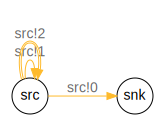

In [7]:
G_wn  = Graph(rate=50000)   
G     = G_wn
G.src = SRC(rom=rom, rate=rate)
G.snk = Node(I=G.src)
G.build()
G.plot_graph()

Then run the simulation.

 #cycles real time  cpu time   #events  1(17)*  rate=50.0kHz
     100   2.000ms      0.0s       178  lasso=1(17)*, real time
   24991 499.820ms      1.9s     44132  src: rom depleted
   24991 499.820ms      1.9s     44132  halt (23ke/cs)


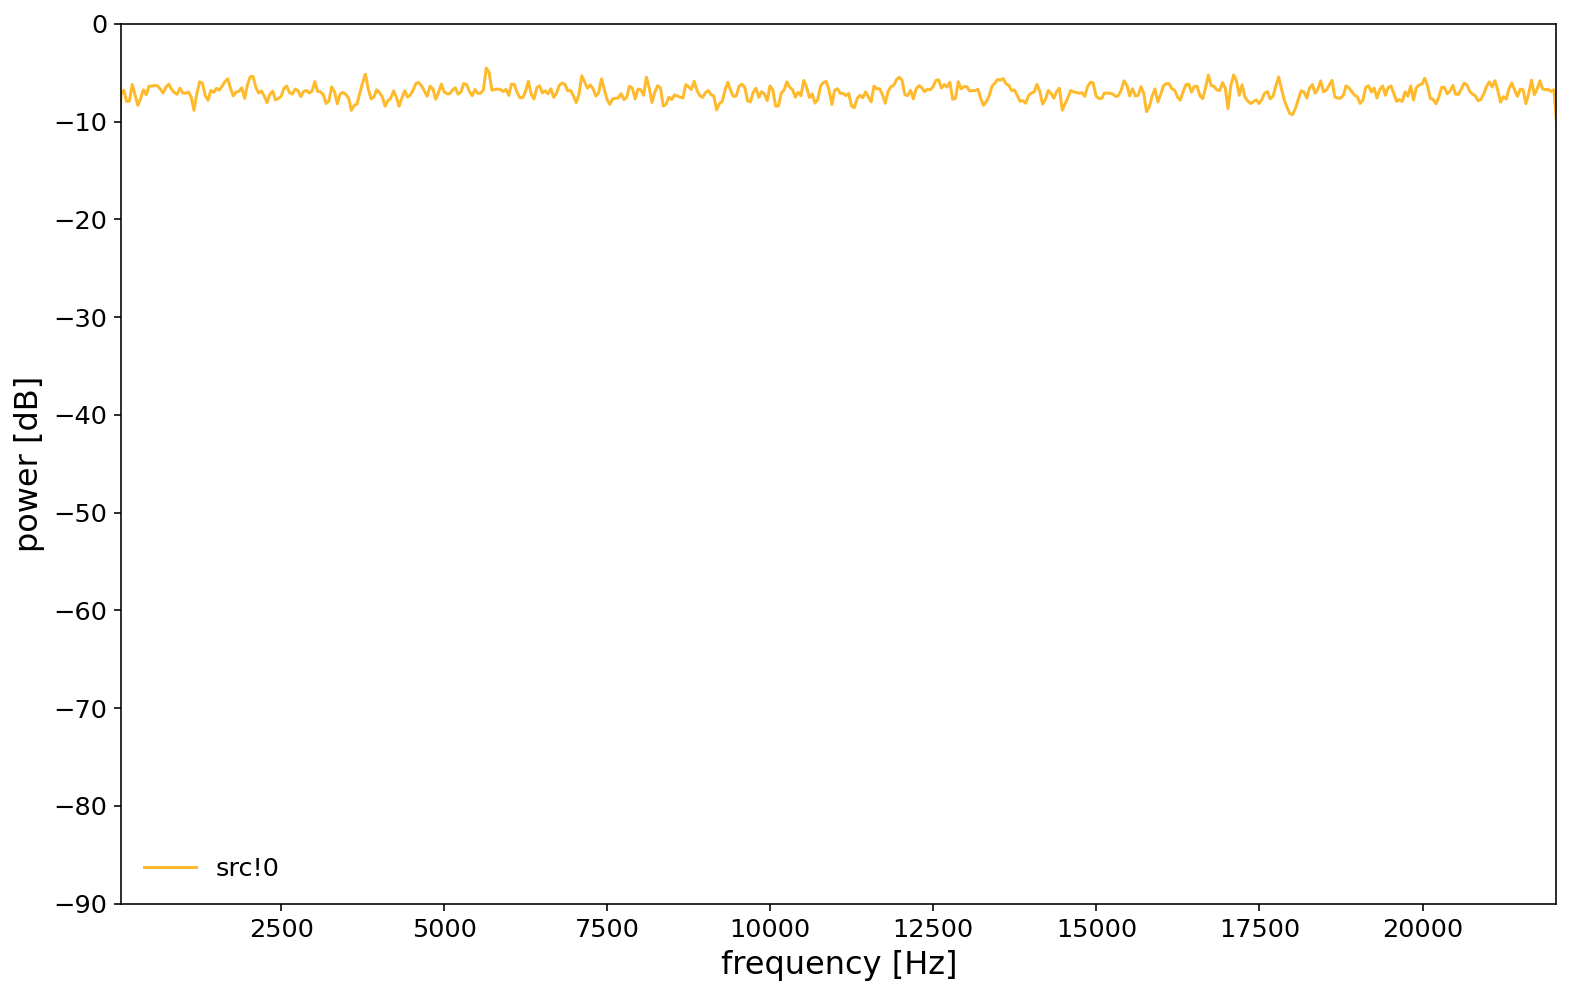

In [8]:
G.sim(T=t)
edges_concern = [G.src.O[0]]
G.plot_periodogram(Edges=edges_concern);

The power spectral density (PSD) of `rom` is approximately flat, which is a typical property of white noise. These two checks prove the validality of our implementation.

### `rom` with a longer duration

If `rom` is generated to a longer one, its mean and variance will be much closer to $\frac{(a+b)}{2}=-0.5$ and $\frac{(b-a)^2}{12}=357903018.75$, respectively. Also, the PSD will be flatter.

## Question 2

In this question, the graph given is firstly copied, and `rom` is plugged in. We have

copy1 (Graph)     : no errors


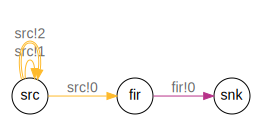

In [9]:
copy1  = Graph(rate=50000)   
G      = copy1
G.src  = SRC(rom=rom, rate=rate)
G.fir  = Node(I=G.src, fo= lambda x: sum([coef[i]*x[Nc-1-i] for i in range(Nc)]))
G.snk  = Node(I=G.fir)
G.fir.I[0].init(x=[0 for n in coef])
G.build()
G.plot_graph()

 #cycles real time  cpu time   #events  1(17)*  rate=50.0kHz
     100   2.000ms      0.0s       266  lasso=1(17)*, real time
   24991 499.820ms      2.5s     66197  src: rom depleted
   24991 499.820ms      2.5s     66197  halt (26ke/cs)


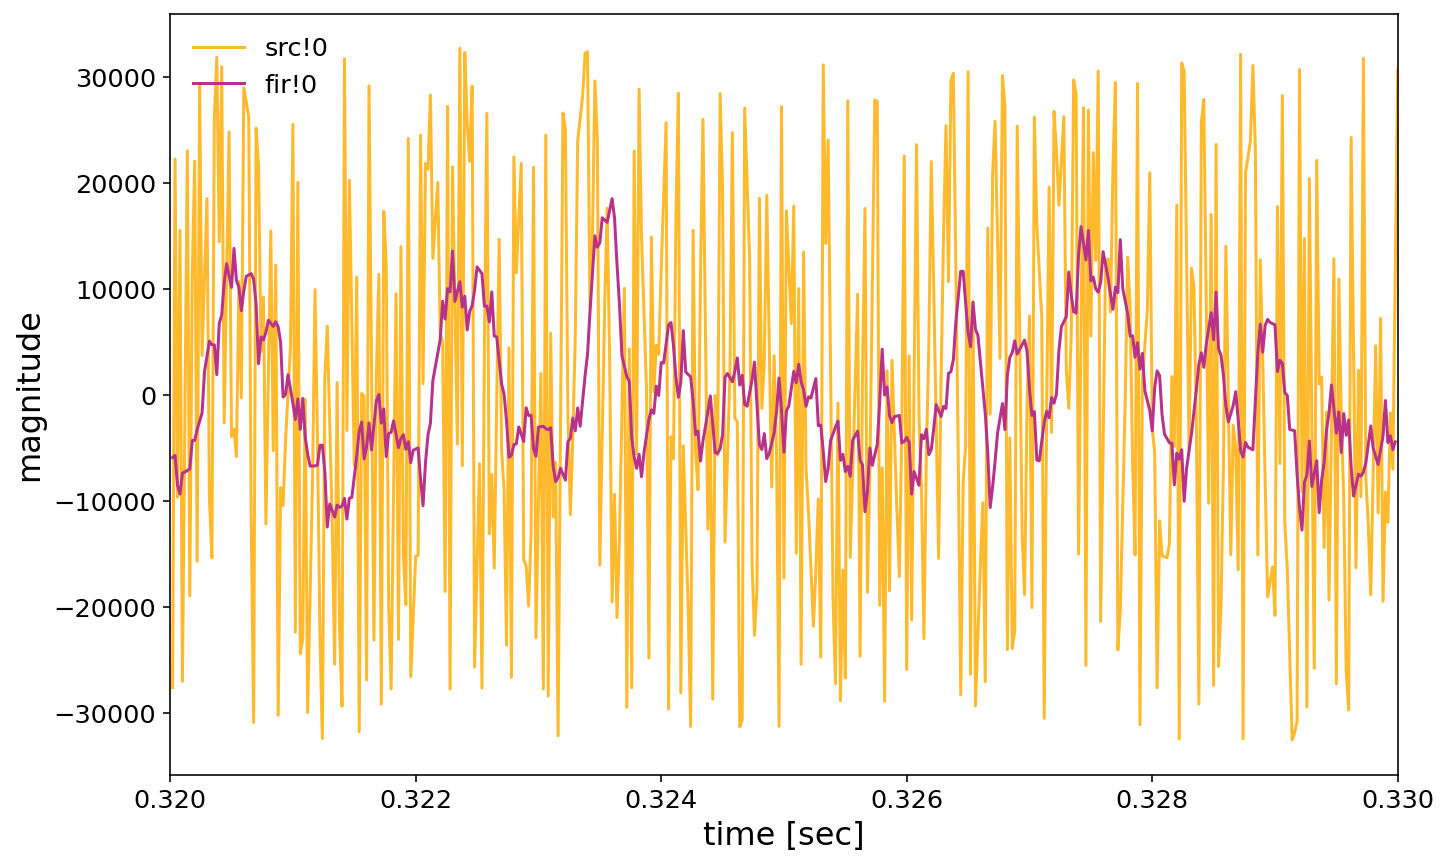

In [10]:
G.sim(T=t)
edges_concern=[G.fir.I[0], G.fir.O[0]]
G.plot_data(tmin=0.32, tmax=0.33, Edges=edges_concern);

In the graph, the white noise is processed by a discrete-time FIR filter of order `Nc`(11), and the output is the weighted sum of the most recent `Nc` values. In our assignment, since the coefficients are the same, the output is actually moving average of length `Nc`, i.e. this FIR filter is a **lowpass** filter.

The signal `rom` is white noise with equal power spectrum density within Nyquist frequency [[1]](#1). Thus `rom` contains not only low but also high frequency components. After applying a lowpass FIR filter, high frequency components will be suppressed.

From the time domain plot, we can observe that the high frequency components of the white noise have been suppressed by FIR filter, and low frequency components remain, which are consistent with the filter properties.

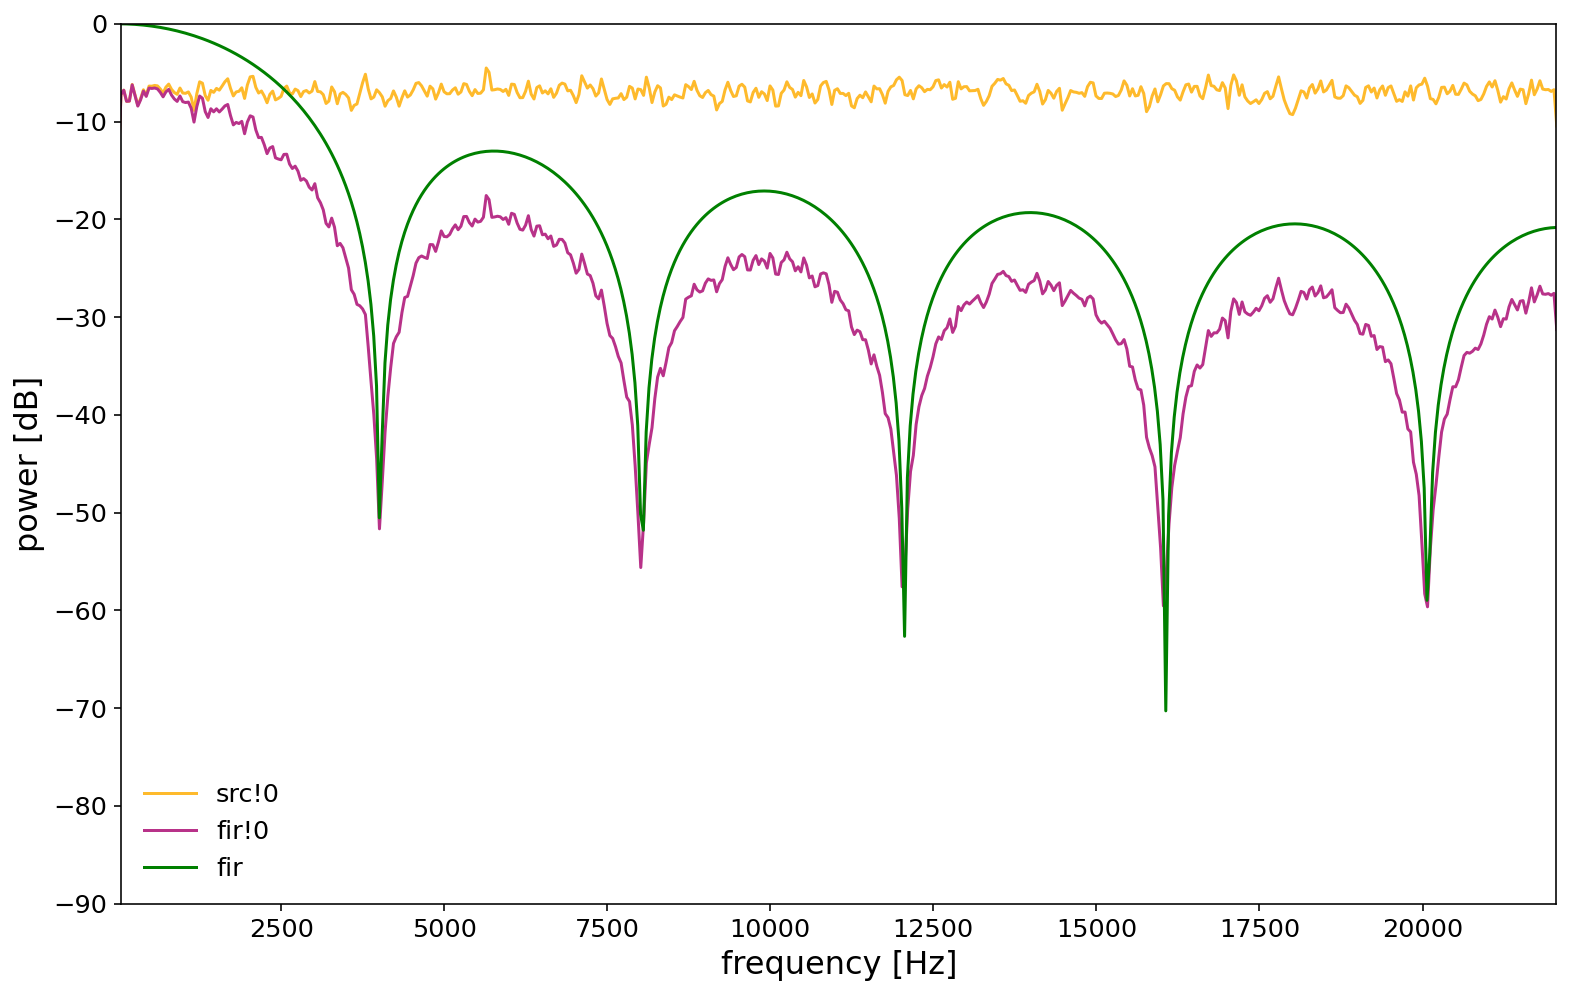

In [11]:
G.plot_periodogram(Edges=edges_concern, fir=coef);

`plot_periodogram()` can help us to plot the estimated power spectrum density (PSD) of concerned edges. With respect to the frequency domain, the filtered signal (fir!0 in purple) remains the low frequency parts, concretely, approximately around 1000Hz, because within this frequency range, the PSD of output (fir!0 in purple) and input (src!0 in yellow) are basically coincident. Whereas when the frequency is higher than about 1000Hz, the PSD of output stream apparently experiences attenuation due to the lowpass FIR filter. The PSD of output stream is equal to the element-wise PSD sum of input stream and FIR filter, since the PSD of input stream is basically flat due to the properties of white noise, the PSD of output stream follows the trend of FIR filter. So the final results are shown as above.

## Question 3

We need to generate a periodic pulse $M,0,...,0,M,0,...,0,M,0...$, with `M` is the max amplitude (the max of `np.int16` in this case), where the frequency is 44100 Hz, pulse rate is 1000 Hz and duration is 0.5 seconds. That is to say we need to assign one `M` every 44.1 sample. Alternatively, we can first generate a sequence of length 441, consisting of ten successive sequence of one `M` and 43 zeros ($M, 0, ..., 0$), followed by a single 0. 

In [12]:
ii16 = np.iinfo(np.int16)
comp_unit = [ii16.max]  # max amplitude: +32767
comp_unit.extend(43*[0])
unit = 10 * comp_unit
unit.append(0)
len(unit)

441

Then repeat this unit sequence of lengh 441 fifty times (44.1k * 0.5s / 441 = 50), we will get desired signal `rom`.

In [13]:
rom = 50*unit

Next we prove that `rom` is indeed what we want.

22050


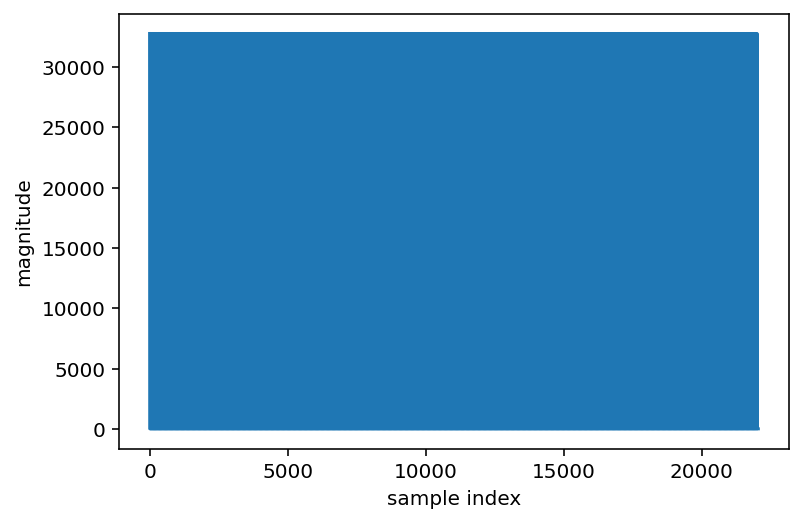

In [14]:
print(len(rom))
plt.plot(rom)
plt.xlabel('sample index')
plt.ylabel('magnitude')
plt.show()

First, we can see that the length of `rom` is exactly $44100*0.5=22050$, but we cannot see the details. Taking a closer look, we plot `rom` for 0.01s, such as `rom[0:441]`. 

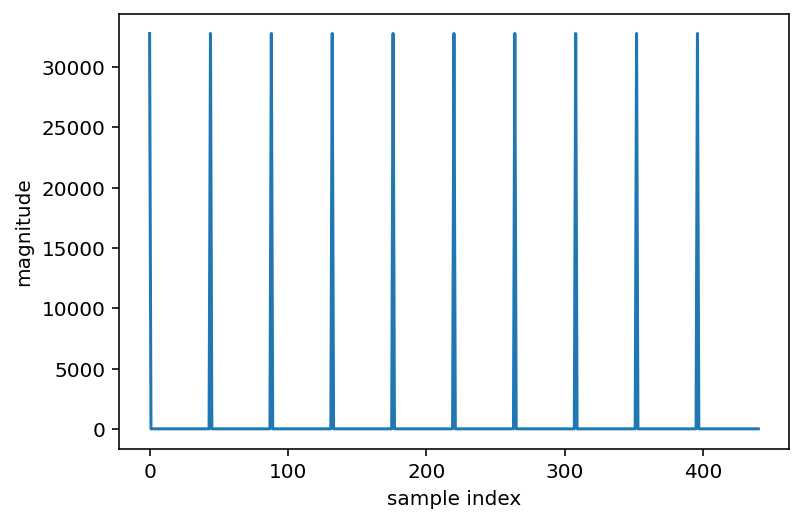

In [15]:
plt.plot(rom[0:441])
plt.xlabel('sample index')
plt.ylabel('magnitude')
plt.show()

We can clearly observe that the pulse frequency is 1000 (10 pulses are uniformly distributed within 0.01 s), which further illustrates the correctness. Alternatively, we can output all the indexes where the value is +32767.

In [16]:
ii16 = np.iinfo(np.int16) 
np.where(np.array(rom) == ii16.max)[0].shape

(500,)

The values which are equal to +32767 are uniformly distributed within 0.5 seconds and the number is 500, proving the correctness in another way.

## Question 4

First, we secondly copy the graph given, then plug the new `rom` generated in question 3.

copy2 (Graph)     : no errors


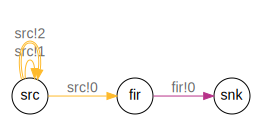

In [17]:
copy2  = Graph(rate=50000)   
G      = copy2
G.src  = SRC(rom=rom, rate=44100)
G.fir  = Node(I=G.src, fo= lambda x: sum([coef[i]*x[Nc-1-i] for i in range(Nc)]))
G.snk  = Node(I=G.fir)
G.fir.I[0].init(x=[0 for n in coef])
G.build()
G.plot_graph()

 #cycles real time  cpu time   #events  1(17)*  rate=50.0kHz
     100   2.000ms      0.0s       266  lasso=1(17)*, real time
    5000 100.000ms      0.6s     13235  pause.
   error: invalid time interval;  tmin= 0 ; tmax= 0.5 graph time= 0.1


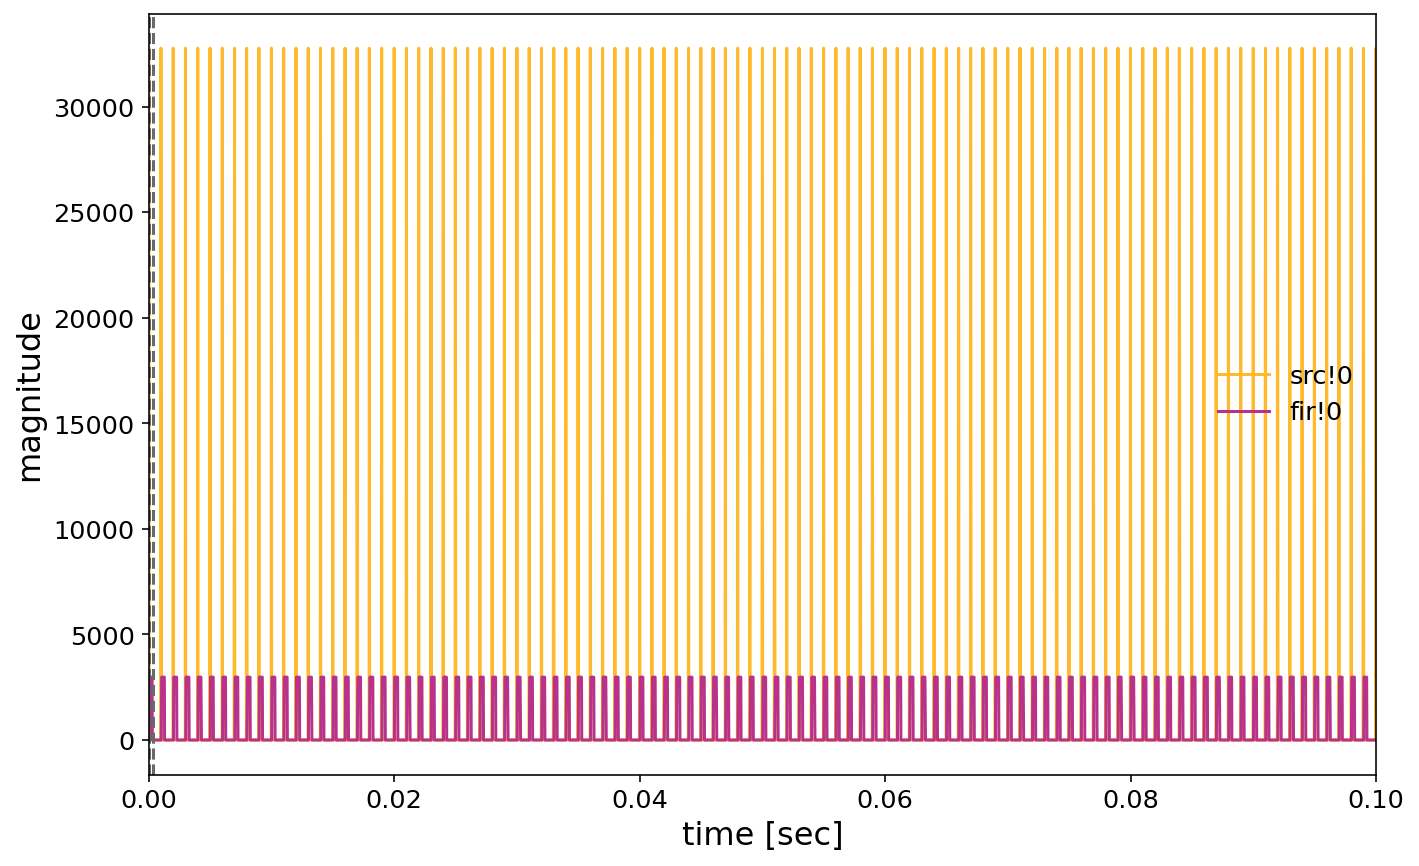

In [18]:
G.sim(T=0.1)
edges_concern=[G.fir.I[0], G.fir.O[0]]
G.plot_data(tmin=0, tmax=t, Edges=edges_concern);

In [19]:
G.print_data(Edges=edges_concern)

,type,min,max,rms
src!0,int,0.0,32767.00,4957
fir!0,int,0.0,2978.82,1487


We simulate for a shorter period to look at the input and output stream clearly in time domain. The shape of the output stream (fir!0 in purple) is compressed exactly 11 times horizontally ($32767/Nc = 32767/11 = 2978.8$), because after applying the FIR filter, the output will be the moving average of length 11, and all other values are 0. Then we can have a look at the frequency domain.

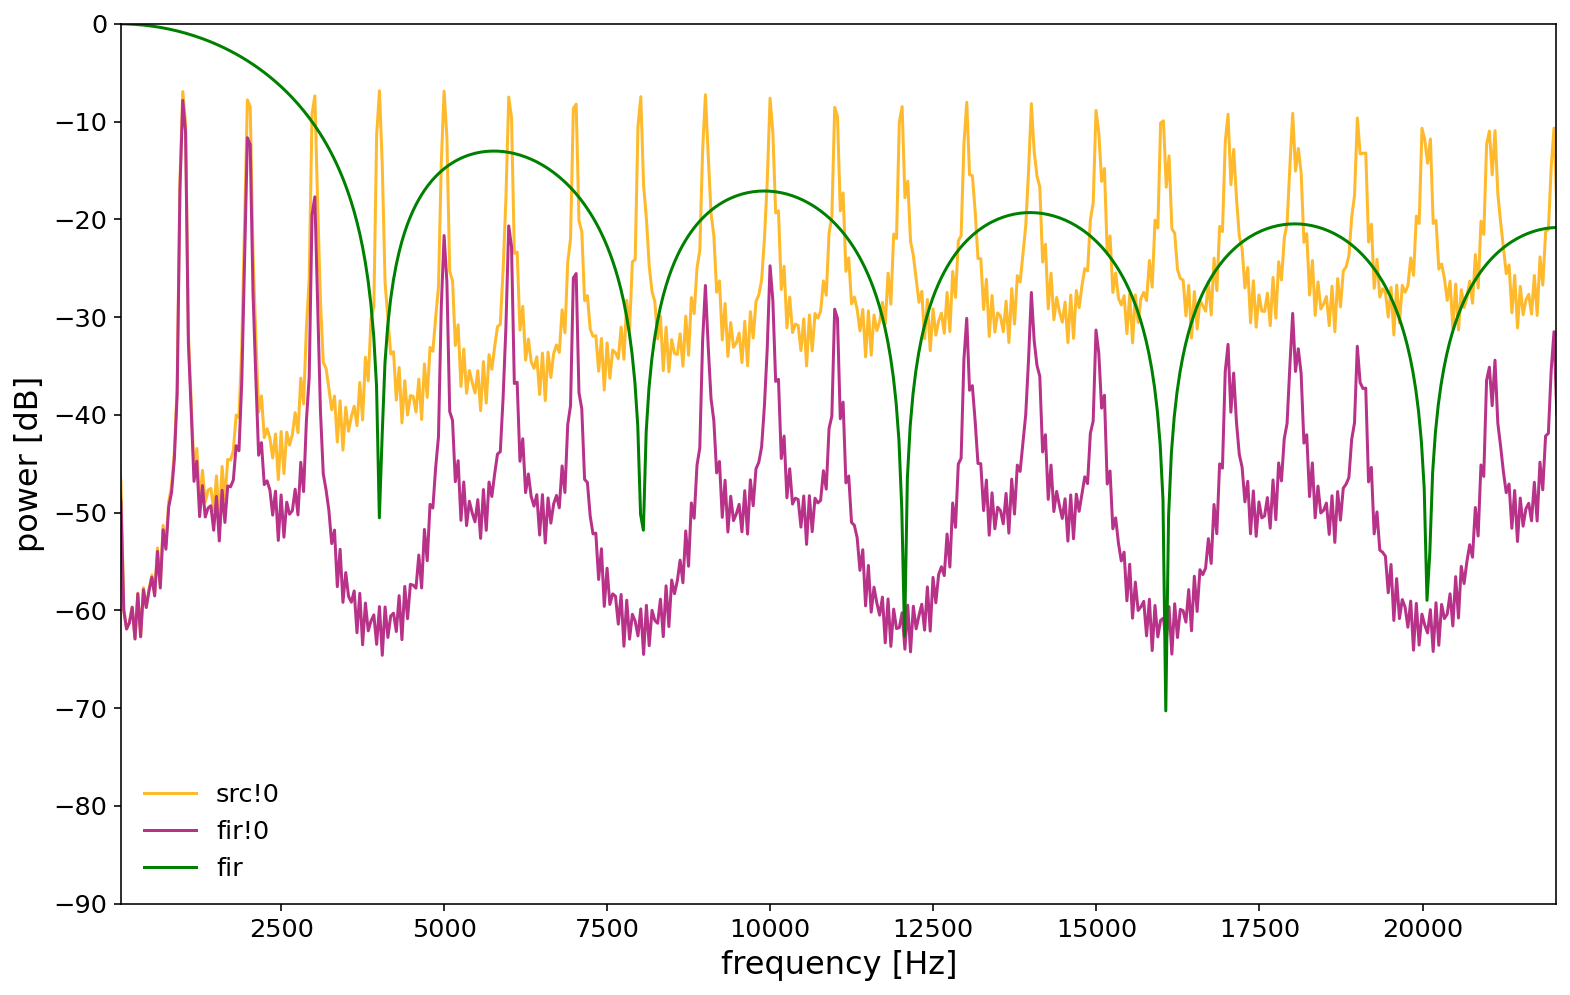

In [20]:
G.plot_periodogram(Edges=edges_concern, fir=coef);

Different from the signal generated in question 1, `rom`, the periodic pulse here shows a periodic estimated PSD. Since the frequency of pulse is 1kHz, there are also power in the integer multiples of 1kHz. Hence, the plot of estimated PSD of `rom` (src!0 in yellow) shows a periodic behavior in frequency domain.

The PSD of `fir` remains the same, with no doubt.

The output stream (fir!0 in purple), which is the processed input stream by FIR filter, its periodicity are patially kept, except around 4kHz, 8kHz, 12kHz (actually they are integer multiple of $44.1k/Nc = 4009.1$Hz)...because of the FIR filter especially suppresses these frequencies due to the moving average. Other peaks remain, but are suppressed, because this FIR filter is lowpass, and the passband is around 1kHz. Only the low frequency part (less than 1kHz approxiamately) are almost the same, which is consistent with the properties of the lowpass filter.

## Bibliography

<a id="1">[1]</a> Eyer, L., & Bartholdi, P. (1999). Variable stars: which Nyquist frequency?. Astronomy and Astrophysics Supplement Series, 135(1), 1-3.